In [1]:
import os
from sklearn.metrics import silhouette_samples
import numpy as np
import json
import matplotlib.pyplot as plt
import math
from itertools import combinations
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.spatial import Delaunay
from scipy.interpolate import griddata
from scipy.stats.mstats import spearmanr
from sklearn import preprocessing
import pandas as pd
import networkx as nx
import bisect
from collections import Counter
from sklearn.manifold import TSNE

def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [2]:
def load_results():
    dumps = []
    for filename in os.listdir('pipeline-results'):
        with open("pipeline-results/"+filename) as json_file:
            projects = json.load(json_file)
            scaledProjects = preprocessing.minmax_scale([i["mappoint"] for i in projects])
        dumps.append({'name':filename,'seed':int(filename[-9:-8]),'projects':scaledProjects.tolist(),
                        'entropies': [i['entropy'] for i in projects], 'lr': projects[0]['lr'], 'perp': projects[0]['perp'],
                      'fbs': [i['project_data']['fb'] for i in projects],'ids': [i['project_data']['id'] for i in projects],
                     'titles': [i['project_data']['title'] for i in projects] })
    return dumps

In [3]:
def getTsneFromDumps(dumps, dim=1, perp=30,lr=100):
    X = np.array([list(sum([(i['projects'][j][0],i['projects'][j][1] )
                       for j in range(len(i['fbs']))], ())) for i in dumps])
    X_embedded = TSNE(n_components=dim,perplexity=perp,learning_rate=lr).fit_transform(X)
    if dim > 1:
        plt.scatter([i[0] for i in X_embedded],[i[1] for i in X_embedded],15,
                    [stability(x['projects'],13) for x in dumps])
        for i in range(len(dumps)):
            dumps[i]['x_tsne'] = float(X_embedded[i][0])
            dumps[i]['y_tsne'] = float(X_embedded[i][1])
    else:
        plt.scatter(X_embedded,[i['perp'] for i in dumps],15,
                    [stability(x['projects'],21) for x in dumps])
        for i in range(len(dumps)):
            dumps[i]['x_tsne'] = float(X_embedded[i][0])
    return dumps

def m_tsne(dumps, dim=1, perp=30,lr=100):
    X = np.array([list(sum([(i['projects'][j][0],i['projects'][j][1] )
                       for j in range(len(i['fbs']))], ())) for i in dumps])

    X_embedded = TSNE(n_components=dim,perplexity=perp,learning_rate=lr).fit_transform(X)

    for i in range(len(dumps)):
        dumps[i]['x_tsne'] = float(X_embedded[i][0])
    return dumps
            

In [4]:
def m_silhouette(projects,fbs):
    similarity_to_cluster_centers = silhouette_samples(np.array([i for i in projects]), labels=np.array( fbs))
    return np.average(similarity_to_cluster_centers)

In [5]:
def m_smallest_dists(projects):
    distances = pdist(projects)
    distances.sort()
    return sum(distances[:len(projects)])/len(projects)


In [6]:
def m_x_y_spread(projects):
    distances = cdist(projects,[[2,2],[2,-2],[-2,-2],[-2,2]])
    distance_measure = (sum([i[0] for i in distances])/sum([i[1] for i in distances]) +
                        sum([i[2] for i in distances])/sum([i[3] for i in distances]))
    return distance_measure

In [7]:
def m_stability(projects,i):
    return math.atan(projects[i][1]/(projects[i][0]+0.0001))

In [8]:
def m_spearmanr(projects):
    return spearmanr([i[0] for i in projects],[i[1] for i in projects]).correlation

In [9]:
def m_mst_graph(projects):
    df = pd.DataFrame(data=projects, columns=['x','y'])
    graph = nx.Graph()
    graph.add_nodes_from(df.iterrows())
    dists = pdist(df[["x", "y"]])
    dists = squareform(dists)
    graph.add_weighted_edges_from([(p1, p2,dists[p1][p2]) for p1, p2 in combinations(df.index.values, 2)])
    graph= nx.minimum_spanning_tree(graph, weight='weight')
    return graph

In [10]:
def getAllMSTGraphs(layouts):
    graphs = []
    for layout in layouts:
        graph = m_mst_graph(pd.DataFrame(data=layout['projects'], columns=['x','y']))
        graphs[layout['name']] = graph
    return graphs

In [11]:
def m_scagnostics(graph):
    weights = [graph[a][b]['weight'] for a,b in graph.edges]
    weights.sort()
    quant25 = np.quantile(weights,0.25)
    quant75 = np.quantile(weights,0.75)
    quant10 = np.quantile(weights,0.1)
    quant90 = np.quantile(weights,0.9)
    quant50 = np.quantile(weights,0.5)
    crit = quant75 + 1.5*(quant75-quant25)
    longEdgesSum = np.sum(list(filter(lambda x: x>crit, weights)))
    outlying = longEdgesSum/np.sum(weights)
    skewed = (quant90-quant50)/(quant90-quant10)
    subgraphs = [graph.copy() for a,b in graph.edges]
    edges = [[a,b] for a,b in graph.edges]
    i= 0
    clumpylist = []
    for g in subgraphs:
        g.remove_edge(edges[i][0],edges[i][1])
        minComp = min(connected_component_subgraphs(g), key=len)
        if len(minComp.edges) >0 and graph[edges[i][0]][edges[i][1]]['weight'] > 0:
            maxEdge = max([g[a][b]['weight'] for a,b in minComp.edges])
            maxEdge = max(0.00001,maxEdge)
            val = 1- (maxEdge/graph[edges[i][0]][edges[i][1]]['weight'])
            clumpylist.append(val)
        i+=1
    clumpy = max(clumpylist)
    sparse = min(1,quant90)
    return {'outlying':outlying,'skewed':skewed,'clumpy':clumpy,'sparse':sparse}

In [12]:
def m_mean_jaccard(graph1,graph2,v):
    c = 1/v
    sumOfVals = 0
    for i in range(v):
        N1 = [n for n in graph1.neighbors(i)]
        N2 = [n for n in graph2.neighbors(i)]
        sumOfVals+= len(list(set(N1) & set(N2)))/len(list(set(N1) | set(N2)))
    return sumOfVals*c

def allMeanJaccardSimilaritiesMST(allGraphs):
    similarities = [{'Dump1':str(p1[0]),
                     'Dump2':str(p2[0]),
                     'value':meanJaccardSimilarity(p1[1], p2[1],92)} 
                    for p1, p2 in combinations(allGraphs, 2)]
    return similarities

#simGraph = allMeanJaccardSimilaritiesMST(graphsFromDump)

In [13]:
def computeClusterTopography(points, values, width, height, interpolation='cubic'):
    # lay grid over the points so that all points are covered
    grid_x, grid_y = np.mgrid[np.min(points[:,0]):np.max(points[:,0]):width*1j, np.min(points[:,1]):np.max(points[:,1]):height*1j]
    return grid_x, grid_y,griddata(np.array(points), np.array(values[:len(points)]), (grid_x, grid_y), method=interpolation, fill_value=np.min(values[:len(points)]))

In [14]:
def calculate_all_measures(dumps):
    dumps = m_tsne(dumps)
    print("tsne mapping computed")
    firstG = m_mst_graph(dumps[0]['projects'])
    for dump in dumps:
        ps = dump['projects']
        graph = m_mst_graph(ps)
        scagnostics = m_scagnostics(graph)
        dump['combDist'] = m_smallest_dists(ps)
        dump['x_y_spread'] = m_x_y_spread(ps)
        dump['outlying'] = scagnostics['outlying']
        dump['skewed'] = scagnostics['skewed']
        dump['sparse'] = scagnostics['sparse']
        dump['spearmanr'] = m_spearmanr(ps)
        dump['stability'] = m_stability(ps,21)
        dump['silhouette'] = m_silhouette(ps,dump['fbs'])
        dump['clumpy'] = scagnostics['clumpy']
        dump['simFirst'] = m_mean_jaccard(graph,firstG,len(ps))
    return dumps

In [15]:
def create_new_dump(dumps):
    dumpsToSave = []
    for perp in set([i['perp'] for i in dumps]):
        for lr in set([i['lr'] for i in dumps]):
            current = list(filter(lambda x: x['lr'] ==lr and x['perp'] == perp, dumps))
            if len(current) > 0:
                current.sort(key=lambda tup: tup['stability'])
                dumpsToSave.append(current[0])
    return dumpsToSave

In [16]:
def sortInGrid(measure1, measure2, size, data):
    stepsize = math.floor(math.sqrt(len(data))/size)
    if stepsize == 0: raise ValueError
    data.sort(key=lambda tup: tup[measure1])
    sampledData = data[::stepsize] 
    grid = [None] * size
    for i in range (0,size):
        grid[i]= sampledData[size*i:size*i+size]
        grid[i].sort(key=lambda tup: tup[measure2])  
    return grid

 Computing grid sorted by 2 measures

In [17]:
def drawGrid(data=[], size=1, m1='lr', m2='perp'):
    grid = sortInGrid(m1,m2, size, data)
    fig, axs = plt.subplots(size, size, figsize=(35, 35))
    fbsdict = {1: '#ad494a', 2: '#e69e57', 3: '#14a5b5',4:'#9467bd', 5:'#989aa1'}
    #clusterdict= {0:'#a6cee3', 1:'#1f78b4', 2:'#b2df8a', 3:'#33a02c',4:'#fb9a99', 5:'#e31a1c', 6:'#fdbf6f', 7:'#ff7f00',8:'#cab2d6',9:'#6a3d9a'}
    for x in range(0,size):
        for y in range(0,size):
            vis = grid[x][y]
            #a,b,c = computeClusterTopography(np.array(vis['projects']), vis['entropies'], 400,400, interpolation='linear')
            #axs[x,y].contourf(a,b,c, levels=[4.1,4.15,4.2,4.25,4.3,4.35,4.4,4.45,4.5,4.55,4.6,4.65,4.7,4.75,4.8,4.85,4.9,4.95,5], cmap="Greys")
            #axs[x,y].pcolormesh(a,b,c, cmap="Greys")
            axs[x, y].scatter([i[0] for i in vis['projects']],[i[1] for i in vis['projects']],
                        10,[fbsdict[i] for i in vis['fbs']])
            axs[x, y].set_title("x: "+ str(round(vis[m2],2))+" y:"+ str(round(vis[m1],2)))

    for ax in fig.get_axes():
        ax.set_facecolor('#0e0e0e')
        plt.setp(ax.spines.values(), color='grey', linewidth=2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


lr80_p3_seed9_HDP.txt


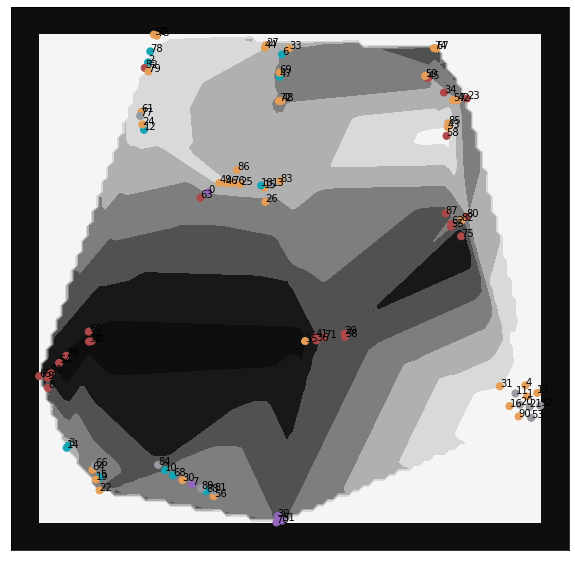

In [61]:
def drawSingleVis(index,dumps):
    vis = dumps[index]
    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    cdict = {1: '#ad494a', 2: '#e69e57', 3: '#14a5b5',4:'#9467bd', 5:'#989aa1',6:'#fff',0:'#fff'}
    a,b,c = computeClusterTopography(np.array(vis['projects']), vis['entropies'], 100,100, interpolation='linear')
    axs.contourf(a,b,c, levels=[0,0.2,0.4,0.6,0.8,1,1.2], cmap="Greys")
    #axs.pcolormesh(a,b,c, cmap="Greys")
    axs.scatter([i[0] for i in vis['projects']],[i[1] for i in vis['projects']],
                    50,[cdict[i] for i in vis['fbs']])
    [axs.annotate(x[0], (x[1], x[2])) for x in [[i, vis['projects'][i][0],
                                                 vis['projects'][i][1]] for i in range(92)]]

    print(vis['name'])
    for ax in fig.get_axes():
        ax.set_facecolor('#0e0e0e')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
  
    

drawSingleVis(4,data)

In [62]:
def compute_uncertainties(data):
    uncertainties = []
    for vis in data:
        points = np.array(vis['projects'])
        values = vis['entropies']
        grid_x, grid_y = np.mgrid[np.min(points[:,0]):np.max(points[:,0]):50*1j, 
                                  np.min(points[:,1]):np.max(points[:,1]):50*1j]
        c = griddata(np.array(points), np.array(values[:len(points)]), (grid_x, grid_y), 
                     method='linear', fill_value=np.min(values[:len(points)]))
        uncertainties.append(c.T.flatten().tolist())
    return uncertainties
 


In [63]:
def measure_extraction(recreate=False):
    if not os.path.isfile('currentCombinedMeasures.json') or recreate:
        if os.path.exists('pipeline-results'):
            tsnedumps = load_results()
            print(str(len(tsnedumps)) + " dumps loaded")
            results = calculate_all_measures(tsnedumps)
            print(str(len(results)) + " measures calculated")
            with open('currentCombinedMeasures.json', 'w') as filehandle:
                json.dump(results, filehandle)

    if not os.path.isfile('current_dump.json') or recreate:
        with open('currentCombinedMeasures.json') as json_file:
            loaded_data = json.load(json_file)
            curr_dump = create_new_dump(loaded_data)
            print(str(len(curr_dump)) + " orderings sampled")
            with open('current_dump.json', 'w') as filehandle:
                json.dump(curr_dump, filehandle)
                
            uncertainties = compute_uncertainties(curr_dump)
            with open('../src/assets/uncertainties.json', 'w') as filehandle:
                json.dump(uncertainties, filehandle)
            print("uncertainty landscapes computed")
    else:
        with open('current_dump.json') as json_file:
            curr_dump = json.load(json_file)
            print(str(len(curr_dump)) + " orderings from already existing dump")
            with open('../src/assets/current_dump.json', 'w') as filehandle:
                json.dump(  curr_dump,filehandle)
    print("everything is saved")

In [64]:
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, Dropdown, FloatSlider, fixed
import ipywidgets as widgets

#uncomment the lines below, if you are using the notebook for the first time
measure_extraction()
with open('../src/assets/current_dump.json') as json_file:
    loadedData = json.load(json_file)   

def s(x,y):
    return IntSlider(min=x,max=y, value=5, continuous_update=False)


def measure(default,name):
    return widgets.Dropdown(
        options=['combDist','x_y_spread','outlying','outlying',
                 'skewed','sparse','spearmanr','stability','silhouette','clumpy','simFirst','x_tsne','perp','lr'],
        value=default,
        description=name+' sorting:',
        disabled=False,
    )


interactive(drawGrid, data=fixed(loadedData), size=s(3,math.floor(math.sqrt(len(loadedData)))), 
            m1=measure('x_tsne','y'), m2=measure('perp','x'))

160 orderings from already existing dump
everything is saved


interactive(children=(IntSlider(value=5, continuous_update=False, description='size', max=12, min=3), Dropdown…